In [475]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**Table of contents**<a id='toc0_'></a>    
- [Zara](#toc1_)    
  - [Greenwashing Detection](#toc1_1_)    
  - [Greenwashing Mitigation](#toc1_2_)    
- [H&M](#toc2_)    
  - [Greenwashing Detection](#toc2_1_)    
  - [Greenwhasing Mitigation](#toc2_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Zara](#toc0_)

In [476]:
gpt = pd.read_excel('./data/scenarios/scenarios_zara_gpt-4o_topk8_paramsall.xlsx')
gpt.drop('Unnamed: 0', axis=1, inplace=True)

llama3 = pd.read_excel('./data/scenarios/scenarios_zara_llama3_instruct_topk8_paramsall.xlsx')
llama3.drop('Unnamed: 0', axis=1, inplace=True)

llama2 = pd.read_excel('./data/scenarios/scenarios_zara_llama2_topk8_paramsall.xlsx')
llama2.drop('Unnamed: 0', axis=1, inplace=True)

mistral = pd.read_excel('./data/scenarios/scenarios_zara_mistral_topk8_paramsall.xlsx')
mistral.drop('Unnamed: 0', axis=1, inplace=True)

phi3 = pd.read_excel('./data/scenarios/scenarios_zara_phi3_14b-instruct_topk8_paramsall.xlsx')
phi3.drop('Unnamed: 0', axis=1, inplace=True)

print(llama3.shape)
llama3.head()

(16, 11)


,category,subcategory,question,decision,answer,source_pages,source_texts,faithfulness_score,faithfulness_feedback,context_relevancy_score,context_relevancy_feedback
0,target,1,How does the company track and report progress...,NaN,See In Answer,NaN,[BEGIN OF SOURCES]\n\nPAGE 35: 6.1.5.4. Metri...,1,YES,0.750,Evaluation:\n\n1. Does the retrieved context m...
1,target,2,What are the key factors or variables that are...,NO,The report does not explicitly outline the key...,"8, 19, 7",[BEGIN OF SOURCES]\n\nPAGE 8: Energy consumpt...,1,YES,0.750,Evaluation:\n\n1. Does the retrieved context m...
2,target,3,Are the ESG factors integrated into the compan...,NO,"Based on the report, it appears that while Ind...","18, 19, 23",[BEGIN OF SOURCES]\n\nPAGE 27: Transition dim...,0,NO,1.125,Evaluation:\n\n1. Does the retrieved context m...
3,target,4,Does the company disclose relevant ESG factors...,NO,The company does not explicitly disclose all r...,"17, 16, 24, 29, 28, 23, 19",[BEGIN OF SOURCES]\n\nPAGE 17: Another mounti...,1,YES,NaN,Evaluation:\n\n**Question 1: Does the retrieve...
4,target,5,Are environmental claims supported by credible...,NO,"Upon reviewing the report, I found that while ...","17, 20, 30, 43",[BEGIN OF SOURCES]\n\nPAGE 36: Investments mu...,0,NO,NaN,Evaluation:\n\n1. Does the retrieved context m...


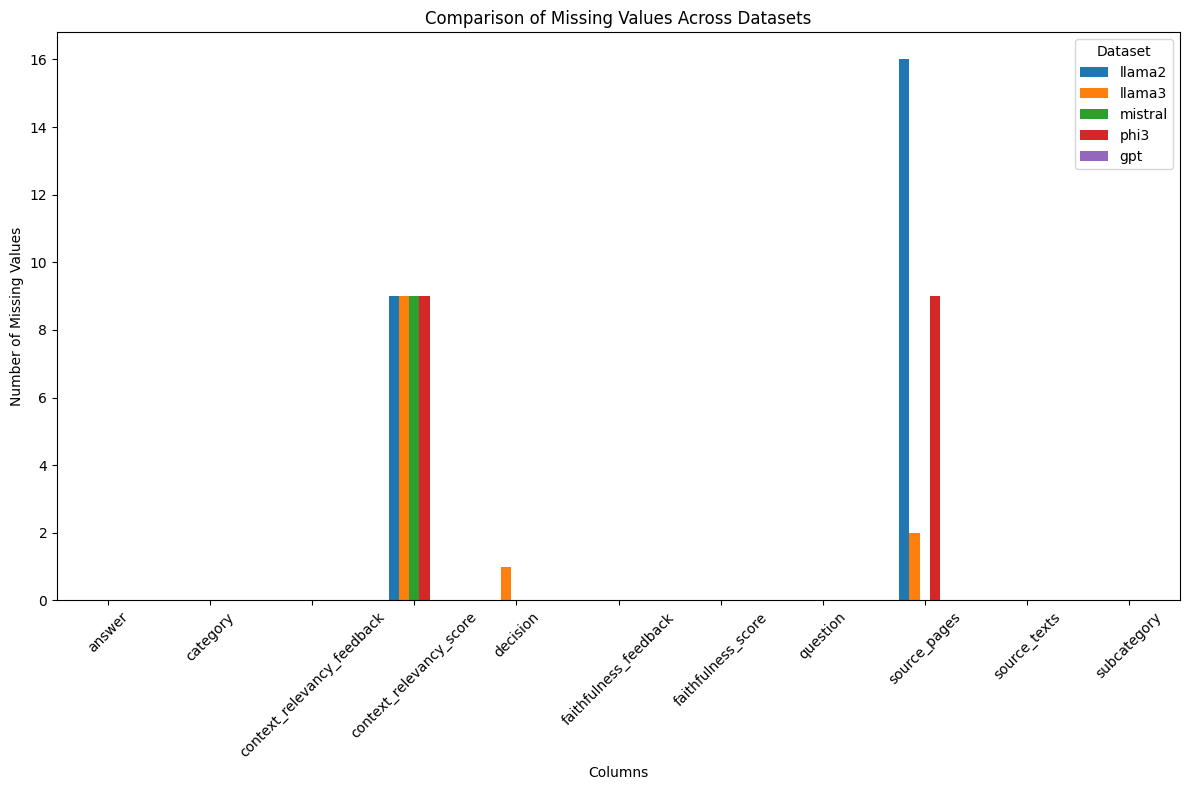

In [477]:
llama2_missing = llama2.isna().sum()
llama3_missing = llama3.isna().sum()
mistral_missing = mistral.isna().sum()
phi3_missing = phi3.isna().sum()
gpt_missing = gpt.isna().sum()


missing_comparison = pd.DataFrame({
    'llama2': llama2_missing,
    'llama3': llama3_missing,
    'mistral': mistral_missing,
    'phi3': phi3_missing,
    'gpt': gpt_missing
}).reset_index()

missing_comparison.columns = ['Column', 'llama2', 'llama3', 'mistral', 'phi3', "gpt"]

missing_comparison.plot(x='Column', kind='bar', figsize=(12, 8))
plt.title('Comparison of Missing Values Across Datasets')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.xticks(rotation=45)
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

## <a id='toc1_1_'></a>[Greenwashing Detection](#toc0_)

In [478]:
llama3_gwd =  llama3.iloc[0:9]
llama2_gwd =  llama2.iloc[0:9]
phi3_gwd =  phi3.iloc[0:9]
mistral_gwd =  mistral.iloc[0:9]
gpt_gwd =  gpt.iloc[0:9]

In [479]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def calculate_similarity(main_dataset, ground_truth, dataset_name):
    all_texts = pd.concat([main_dataset['answer'], ground_truth['answer']])

    vectorizer = TfidfVectorizer(min_df=1, stop_words="english")
    tfidf_matrix = vectorizer.fit_transform(all_texts)

    main_dataset_tfidf = tfidf_matrix[:len(main_dataset)]
    ground_truth_tfidf = tfidf_matrix[len(main_dataset):]

    cosine_similarities = cosine_similarity(main_dataset_tfidf, ground_truth_tfidf)

    diagonal_values = np.diagonal(cosine_similarities)

    main_dataset[f"gt_similarity_{dataset_name}"] = diagonal_values

    return main_dataset

llama3 = calculate_similarity(llama3_gwd, gpt_gwd, "llama3")
llama2 = calculate_similarity(llama2_gwd, gpt_gwd, "llama2")
phi3 = calculate_similarity(phi3_gwd, gpt_gwd, "phi3")
mistral = calculate_similarity(mistral_gwd, gpt_gwd, "mistral")

llama3["gt_similarity_llama3"] = llama3.get("gt_similarity_llama3", pd.Series(dtype=float))
llama2["gt_similarity_llama2"] = llama2.get("gt_similarity_llama2", pd.Series(dtype=float))
phi3["gt_similarity_phi3"] = phi3.get("gt_similarity_phi3", pd.Series(dtype=float))
mistral["gt_similarity_mistral"] = mistral.get("gt_similarity_mistral", pd.Series(dtype=float))

similarity_df = pd.DataFrame({
    "llama3": llama3["gt_similarity_llama3"],
    "llama2": llama2["gt_similarity_llama2"],
    "phi3": phi3["gt_similarity_phi3"],
    "mistral": mistral["gt_similarity_mistral"]
})

similarity_df

C:\Users\Arne\AppData\Local\Temp\ipykernel_23268\1715262476.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_dataset[f"gt_similarity_{dataset_name}"] = diagonal_values
C:\Users\Arne\AppData\Local\Temp\ipykernel_23268\1715262476.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_dataset[f"gt_similarity_{dataset_name}"] = diagonal_values
C:\Users\Arne\AppData\Local\Temp\ipykernel_23268\1715262476.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

,llama3,llama2,phi3,mistral
0,0.000000,0.294753,0.352804,0.292766
1,0.141019,0.199952,0.167583,0.129036
2,0.492912,0.262893,0.472063,0.552333
3,0.383490,0.289703,0.377071,0.510386
4,0.250559,0.275442,0.213116,0.138490
5,0.221829,0.163405,0.181627,0.143090
6,0.228265,0.151642,0.158686,0.123300
7,0.196687,0.035011,0.158395,0.167996
8,0.181663,0.154129,0.158032,0.256662


In [480]:
def get_mean(ds):
    cols = ds.columns
    avg_list = {}
    for col in cols:
        num_zero = len(ds[ds[col] == 0.0])
        col_sum = ds[col].sum()
        avg = col_sum / (len(ds[col]) - num_zero)
        avg_list[col] = avg
    
    return avg_list

In [481]:
print(get_mean(similarity_df))

{'llama3': 0.26205302419681875, 'llama2': 0.20299233286512297, 'phi3': 0.24881967391680415, 'mistral': 0.2571175596607119}


In [482]:
similarity_df['highest_score_column'] = similarity_df.idxmax(axis=1)
highest_count = similarity_df['highest_score_column'].value_counts()
highest_count

highest_score_column
mistral    3
llama3     3
llama2     2
phi3       1
Name: count, dtype: int64

## <a id='toc1_2_'></a>[Greenwashing Mitigation](#toc0_)

In [483]:
gpt = pd.read_excel('./data/scenarios/scenarios_zara_gpt-4o_topk8_paramsall.xlsx')
gpt.drop('Unnamed: 0', axis=1, inplace=True)

llama3 = pd.read_excel('./data/scenarios/scenarios_zara_llama3_instruct_topk8_paramsall.xlsx')
llama3.drop('Unnamed: 0', axis=1, inplace=True)

llama2 = pd.read_excel('./data/scenarios/scenarios_zara_llama2_topk8_paramsall.xlsx')
llama2.drop('Unnamed: 0', axis=1, inplace=True)

mistral = pd.read_excel('./data/scenarios/scenarios_zara_mistral_topk8_paramsall.xlsx')
mistral.drop('Unnamed: 0', axis=1, inplace=True)

phi3 = pd.read_excel('./data/scenarios/scenarios_zara_phi3_14b-instruct_topk8_paramsall.xlsx')
phi3.drop('Unnamed: 0', axis=1, inplace=True)

In [484]:
llama3_gwm =  llama3.iloc[10:]
llama2_gwm =  llama2.iloc[10:]
phi3_gwm =  phi3.iloc[10:]
mistral_gwm =  mistral.iloc[10:]
gpt_gwm =  gpt.iloc[10:]

In [485]:
llama3 = calculate_similarity(llama3_gwm, gpt_gwm, "llama3")
llama2 = calculate_similarity(llama2_gwm, gpt_gwm, "llama2")
phi3 = calculate_similarity(phi3_gwm, gpt_gwm, "phi3")
mistral = calculate_similarity(mistral_gwm, gpt_gwm, "mistral")

llama3["gt_similarity_llama3"] = llama3.get("gt_similarity_llama3", pd.Series(dtype=float))
llama2["gt_similarity_llama2"] = llama2.get("gt_similarity_llama2", pd.Series(dtype=float))
phi3["gt_similarity_phi3"] = phi3.get("gt_similarity_phi3", pd.Series(dtype=float))
mistral["gt_similarity_mistral"] = mistral.get("gt_similarity_mistral", pd.Series(dtype=float))

similarity_df = pd.DataFrame({
    "llama3": llama3["gt_similarity_llama3"],
    "llama2": llama2["gt_similarity_llama2"],
    "phi3": phi3["gt_similarity_phi3"],
    "mistral": mistral["gt_similarity_mistral"]
})

similarity_df

C:\Users\Arne\AppData\Local\Temp\ipykernel_23268\1715262476.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_dataset[f"gt_similarity_{dataset_name}"] = diagonal_values
C:\Users\Arne\AppData\Local\Temp\ipykernel_23268\1715262476.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_dataset[f"gt_similarity_{dataset_name}"] = diagonal_values
C:\Users\Arne\AppData\Local\Temp\ipykernel_23268\1715262476.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

,llama3,llama2,phi3,mistral
10,0.221783,0.103614,0.250940,0.179283
11,0.354060,0.198532,0.270391,0.323588
12,0.267303,0.232599,0.322114,0.100130
13,0.135634,0.125964,0.180227,0.158728
14,0.226977,0.136470,0.235922,0.137135
15,0.304920,0.203586,0.590231,0.125427


In [486]:
print(get_mean(similarity_df))

{'llama3': 0.2517794771471202, 'llama2': 0.16679424397843745, 'phi3': 0.3083039162149606, 'mistral': 0.17071516619251456}


In [487]:
similarity_df['highest_score_column'] = similarity_df.idxmax(axis=1)
highest_count = similarity_df['highest_score_column'].value_counts()
highest_count

highest_score_column
phi3      5
llama3    1
Name: count, dtype: int64

# <a id='toc2_'></a>[H&M](#toc0_)

## <a id='toc2_1_'></a>[Greenwashing Detection](#toc0_)

In [488]:
gpt = pd.read_excel('./data/scenarios/scenarios_hm_gpt-4o_topk8_paramsall.xlsx')
gpt.drop('Unnamed: 0', axis=1, inplace=True)

llama3 = pd.read_excel('./data/scenarios/scenarios_hm_llama3_instruct_topk8_paramsall.xlsx')
llama3.drop('Unnamed: 0', axis=1, inplace=True)

llama2 = pd.read_excel('./data/scenarios/scenarios_hm_llama2_topk8_paramsall.xlsx')
llama2.drop('Unnamed: 0', axis=1, inplace=True)

mistral = pd.read_excel('./data/scenarios/scenarios_hm_mistral_topk8_paramsall.xlsx')
mistral.drop('Unnamed: 0', axis=1, inplace=True)

phi3 = pd.read_excel('./data/scenarios/scenarios_hm_phi3_14b-instruct_topk8_paramsall.xlsx')
phi3.drop('Unnamed: 0', axis=1, inplace=True)

llama3.head()

,category,subcategory,question,decision,answer,source_pages,source_texts,faithfulness_score,faithfulness_feedback,context_relevancy_score,context_relevancy_feedback
0,target,1,How does the company track and report progress...,YES,"According to the report, H&M Group tracks and ...","9, 24, 41",[BEGIN OF SOURCES]\n\nPAGE 76: Read more belo...,0,NO,0.750,To evaluate if the retrieved context from the ...
1,target,2,What are the key factors or variables that are...,NO,"Based on the report, I did not find any key fa...",NaN,[BEGIN OF SOURCES]\n\nPAGE 25: fulfilment of ...,0,NO,NaN,Evaluation:\n\n1. Does the retrieved context m...
2,target,3,Are the ESG factors integrated into the compan...,NO,Although the company mentions that climate ris...,"27, 36, 38",[BEGIN OF SOURCES]\n\nPAGE 27: The executive ...,1,YES,0.375,**Evaluation**\n\n1. Does the retrieved contex...
3,target,4,Does the company disclose relevant ESG factors...,YES,"Based on the report, H&M Group does disclose r...","34, 38, 40",[BEGIN OF SOURCES]\n\nPAGE 36: Launching new ...,1,YES,NaN,Evaluation:\n\n1. Does the retrieved context m...
4,target,5,Are environmental claims supported by credible...,NO,While the report provides some evidence to sup...,"24, 37, 79","[BEGIN OF SOURCES]\n\nPAGE 88: Accordingly, t...",1,YES,0.250,Evaluation of the retrieved context:\n\n1. Doe...


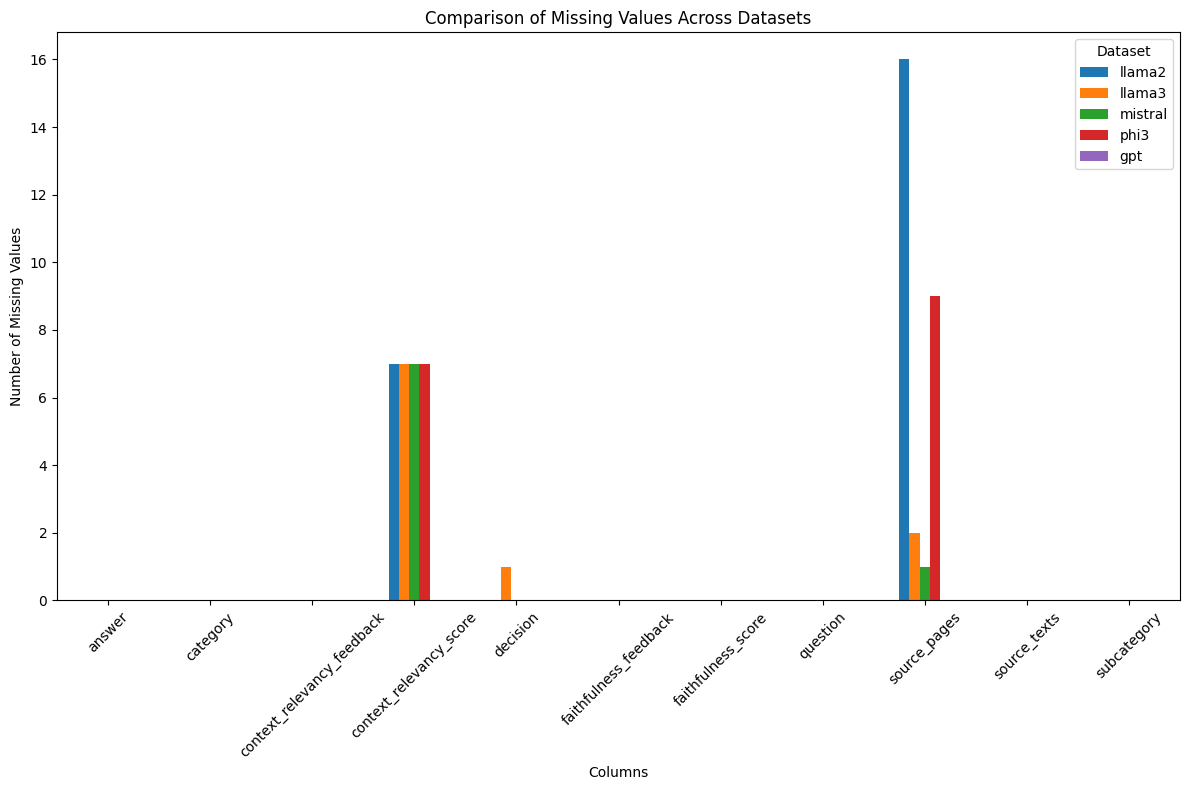

In [489]:
llama2_missing = llama2.isna().sum()
llama3_missing = llama3.isna().sum()
mistral_missing = mistral.isna().sum()
phi3_missing = phi3.isna().sum()
gpt_missing = gpt.isna().sum()


missing_comparison = pd.DataFrame({
    'llama2': llama2_missing,
    'llama3': llama3_missing,
    'mistral': mistral_missing,
    'phi3': phi3_missing,
    'gpt': gpt_missing
}).reset_index()

missing_comparison.columns = ['Column', 'llama2', 'llama3', 'mistral', 'phi3', "gpt"]

missing_comparison.plot(x='Column', kind='bar', figsize=(12, 8))
plt.title('Comparison of Missing Values Across Datasets')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.xticks(rotation=45)
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

In [490]:
llama3_gwd =  llama3.iloc[9:]
llama2_gwd =  llama2.iloc[9:]
phi3_gwd =  phi3.iloc[9:]
mistral_gwd =  mistral.iloc[9:]
gpt_gwd =  gpt.iloc[9:]

In [491]:
llama3 = calculate_similarity(llama3_gwd, gpt_gwd, "llama3")
llama2 = calculate_similarity(llama2_gwd, gpt_gwd, "llama2")
phi3 = calculate_similarity(phi3_gwd, gpt_gwd, "phi3")
mistral = calculate_similarity(mistral_gwd, gpt_gwd, "mistral")

llama3["gt_similarity_llama3"] = llama3.get("gt_similarity_llama3", pd.Series(dtype=float))
llama2["gt_similarity_llama2"] = llama2.get("gt_similarity_llama2", pd.Series(dtype=float))
phi3["gt_similarity_phi3"] = phi3.get("gt_similarity_phi3", pd.Series(dtype=float))
mistral["gt_similarity_mistral"] = mistral.get("gt_similarity_mistral", pd.Series(dtype=float))

similarity_df = pd.DataFrame({
    "llama3": llama3["gt_similarity_llama3"],
    "llama2": llama2["gt_similarity_llama2"],
    "phi3": phi3["gt_similarity_phi3"],
    "mistral": mistral["gt_similarity_mistral"]
})

similarity_df

C:\Users\Arne\AppData\Local\Temp\ipykernel_23268\1715262476.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_dataset[f"gt_similarity_{dataset_name}"] = diagonal_values
C:\Users\Arne\AppData\Local\Temp\ipykernel_23268\1715262476.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_dataset[f"gt_similarity_{dataset_name}"] = diagonal_values
C:\Users\Arne\AppData\Local\Temp\ipykernel_23268\1715262476.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

,llama3,llama2,phi3,mistral
9,0.091923,0.151190,0.092499,0.159021
10,0.325094,0.182292,0.289514,0.164750
11,0.355782,0.187271,0.366639,0.241073
12,0.290569,0.262639,0.305896,0.478355
13,0.000000,0.060803,0.124534,0.191698
14,0.109374,0.138484,0.087958,0.094132
15,0.171076,0.304636,0.261265,0.286555


In [492]:
print(get_mean(similarity_df))

{'llama3': 0.22396970324190654, 'llama2': 0.18390234264828692, 'phi3': 0.21832949593933937, 'mistral': 0.23079764317124005}


In [493]:
similarity_df['highest_score_column'] = similarity_df.idxmax(axis=1)
highest_count = similarity_df['highest_score_column'].value_counts()
highest_count

highest_score_column
mistral    3
llama2     2
llama3     1
phi3       1
Name: count, dtype: int64

## <a id='toc2_2_'></a>[Greenwhasing Mitigation](#toc0_)

In [500]:
gpt_ = pd.read_excel('./data/scenarios/scenarios_hm_gpt-4o_topk8_paramsall.xlsx')

llama3 = pd.read_excel('./data/scenarios/scenarios_hm_llama3_instruct_topk8_paramsall.xlsx')
llama3.drop('Unnamed: 0', axis=1, inplace=True)

llama2 = pd.read_excel('./data/scenarios/scenarios_hm_llama2_topk8_paramsall.xlsx')
llama2.drop('Unnamed: 0', axis=1, inplace=True)

mistral = pd.read_excel('./data/scenarios/scenarios_hm_mistral_topk8_paramsall.xlsx')
mistral.drop('Unnamed: 0', axis=1, inplace=True)

phi3 = pd.read_excel('./data/scenarios/scenarios_hm_phi3_14b-instruct_topk8_paramsall.xlsx')
phi3.drop('Unnamed: 0', axis=1, inplace=True)

In [501]:
llama3_gwm =  llama3.iloc[10:]
llama2_gwm =  llama2.iloc[10:]
phi3_gwm =  phi3.iloc[10:]
mistral_gwm =  mistral.iloc[10:]
gpt_gwm =  gpt.iloc[10:]

In [502]:
llama3 = calculate_similarity(llama3_gwm, gpt_gwm, "llama3")
llama2 = calculate_similarity(llama2_gwm, gpt_gwm, "llama2")
phi3 = calculate_similarity(phi3_gwm, gpt_gwm, "phi3")
mistral = calculate_similarity(mistral_gwm, gpt_gwm, "mistral")

llama3["gt_similarity_llama3"] = llama3.get("gt_similarity_llama3", pd.Series(dtype=float))
llama2["gt_similarity_llama2"] = llama2.get("gt_similarity_llama2", pd.Series(dtype=float))
phi3["gt_similarity_phi3"] = phi3.get("gt_similarity_phi3", pd.Series(dtype=float))
mistral["gt_similarity_mistral"] = mistral.get("gt_similarity_mistral", pd.Series(dtype=float))

similarity_df = pd.DataFrame({
    "llama3": llama3["gt_similarity_llama3"],
    "llama2": llama2["gt_similarity_llama2"],
    "phi3": phi3["gt_similarity_phi3"],
    "mistral": mistral["gt_similarity_mistral"]
})

similarity_df

C:\Users\Arne\AppData\Local\Temp\ipykernel_23268\1715262476.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_dataset[f"gt_similarity_{dataset_name}"] = diagonal_values
C:\Users\Arne\AppData\Local\Temp\ipykernel_23268\1715262476.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_dataset[f"gt_similarity_{dataset_name}"] = diagonal_values
C:\Users\Arne\AppData\Local\Temp\ipykernel_23268\1715262476.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

,llama3,llama2,phi3,mistral
10,0.314975,0.183363,0.280115,0.159913
11,0.345799,0.182746,0.348116,0.240811
12,0.291695,0.260964,0.303613,0.476841
13,0.000000,0.062415,0.114731,0.187619
14,0.115279,0.139080,0.093759,0.101847
15,0.175290,0.292755,0.251516,0.284706


In [503]:
print(get_mean(similarity_df))

{'llama3': 0.2486074960356511, 'llama2': 0.1868870774779603, 'phi3': 0.23197481885279228, 'mistral': 0.2419559873583722}


In [504]:
similarity_df['highest_score_column'] = similarity_df.idxmax(axis=1)
highest_count = similarity_df['highest_score_column'].value_counts()
highest_count

highest_score_column
mistral    2
llama2     2
llama3     1
phi3       1
Name: count, dtype: int64